# Market Sentiment vs Trading Behavior Analysis
### Uncovering Hidden Patterns in Fear & Greed Cycles

This analysis explores the intricate relationship between market sentiment (Fear & Greed Index) and actual trading behavior on Hyperliquid, revealing actionable insights for strategic trading decisions.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
import os
warnings.filterwarnings('ignore')

# Create outputs directory
os.makedirs('outputs', exist_ok=True)

plt.style.use('dark_background')
sns.set_palette("husl")

emotion_colors = {
    'fear': '#ff4757',
    'greed': '#2ed573', 
    'neutral': '#ffa502',
    'extreme_fear': '#8b0000',
    'extreme_greed': '#006400',
    'accent': '#3742fa'
}

## Data Ingestion & Preprocessing

In [19]:
fear_greed = pd.read_csv('csv_files/fear_greed_index (1).csv')
trading_data = pd.read_csv('csv_files/historical_data.csv')

fear_greed['date'] = pd.to_datetime(fear_greed['date'])
trading_data['date'] = pd.to_datetime(trading_data['Timestamp IST'].str.split(' ').str[0], format='%d-%m-%Y')
trading_data['hour'] = pd.to_datetime(trading_data['Timestamp IST'], format='%d-%m-%Y %H:%S').dt.hour

sentiment_map = {
    'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4
}
fear_greed['sentiment_score'] = fear_greed['classification'].map(sentiment_map)

trading_metrics = trading_data.groupby(['date', 'Account']).agg({
    'Size USD': ['sum', 'count', 'mean'],
    'Closed PnL': ['sum', 'mean'],
    'Fee': 'sum',
    'Side': lambda x: (x == 'BUY').mean()
}).round(4)

trading_metrics.columns = ['volume', 'trades', 'avg_trade_size', 'total_pnl', 'avg_pnl', 'fees', 'buy_ratio']
trading_metrics = trading_metrics.reset_index()

daily_metrics = trading_metrics.groupby('date').agg({
    'volume': 'sum',
    'trades': 'sum', 
    'total_pnl': 'sum',
    'avg_pnl': 'mean',
    'buy_ratio': 'mean',
    'Account': 'nunique'
}).rename(columns={'Account': 'active_traders'})

merged_data = pd.merge(fear_greed, daily_metrics, on='date', how='inner')
merged_data['pnl_per_volume'] = merged_data['total_pnl'] / merged_data['volume']
merged_data['efficiency_ratio'] = merged_data['total_pnl'] / (merged_data['volume'] + 1e-6)

print(f"Analysis period: {merged_data['date'].min()} to {merged_data['date'].max()}")
print(f"Total trading days: {len(merged_data)}")
print(f"Sentiment distribution:\n{merged_data['classification'].value_counts()}")

Analysis period: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Total trading days: 479
Sentiment distribution:
classification
Greed            193
Extreme Greed    114
Fear              91
Neutral           67
Extreme Fear      14
Name: count, dtype: int64


## Market Sentiment Landscape

In [20]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Fear & Greed Evolution', 'Sentiment Distribution', 
                   'Volume vs Sentiment', 'PnL Efficiency by Sentiment'),
    specs=[[{"secondary_y": True}, {"type": "pie"}],
           [{"secondary_y": True}, {"secondary_y": True}]]
)

color_map = {'Extreme Fear': emotion_colors['extreme_fear'], 'Fear': emotion_colors['fear'], 
             'Neutral': emotion_colors['neutral'], 'Greed': emotion_colors['greed'], 
             'Extreme Greed': emotion_colors['extreme_greed']}

fig.add_trace(
    go.Scatter(x=merged_data['date'], y=merged_data['value'],
               mode='lines', name='F&G Index', line=dict(width=2, color=emotion_colors['accent'])),
    row=1, col=1
)

sentiment_counts = merged_data['classification'].value_counts()
fig.add_trace(
    go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values,
           marker_colors=[color_map[x] for x in sentiment_counts.index],
           hole=0.4, name="Sentiment"),
    row=1, col=2
)

for sentiment in merged_data['classification'].unique():
    subset = merged_data[merged_data['classification'] == sentiment]
    fig.add_trace(
        go.Scatter(x=subset['volume'], y=subset['total_pnl'],
                   mode='markers', name=sentiment,
                   marker=dict(color=color_map[sentiment], size=8, opacity=0.7)),
        row=2, col=1
    )

efficiency_by_sentiment = merged_data.groupby('classification')['efficiency_ratio'].mean().sort_values(ascending=False)
fig.add_trace(
    go.Bar(x=efficiency_by_sentiment.index, y=efficiency_by_sentiment.values,
           marker_color=[color_map[x] for x in efficiency_by_sentiment.index],
           name='Efficiency'),
    row=2, col=2
)

fig.update_layout(
    height=800, 
    title_text="Market Sentiment Analysis Dashboard",
    title_x=0.5,
    template='plotly_dark',
    showlegend=True
)

fig.show()
fig.write_image('outputs/market_sentiment_dashboard.png', width=1200, height=800)

In [21]:
# !pip install kaleido


## Trading Behavior Patterns

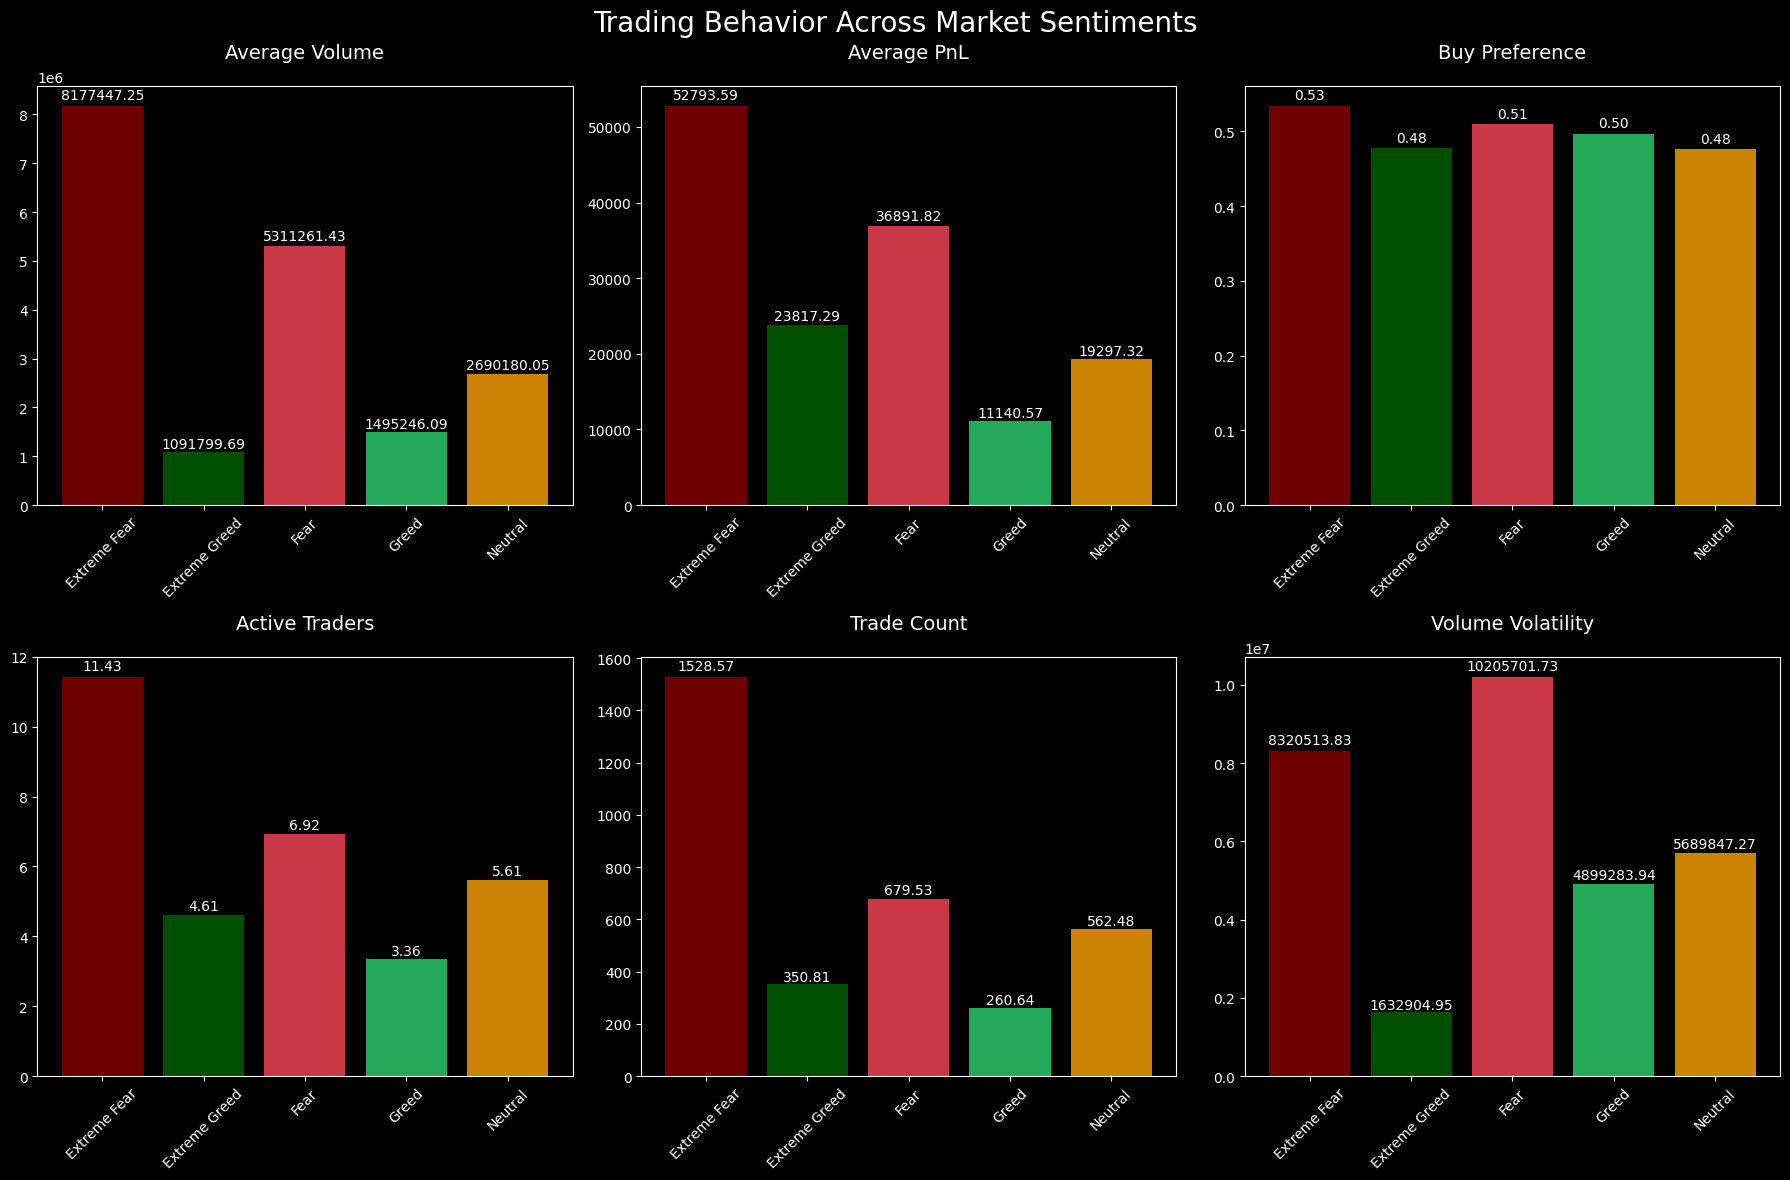


📊 Key Behavioral Insights:
• Highest volume during: Extreme Fear
• Most profitable sentiment: Extreme Fear
• Strongest buy bias: Extreme Fear
• Most active period: Extreme Fear


In [22]:
behavior_analysis = merged_data.groupby('classification').agg({
    'volume': ['mean', 'std'],
    'total_pnl': ['mean', 'std'], 
    'buy_ratio': 'mean',
    'active_traders': 'mean',
    'trades': 'mean'
}).round(4)

behavior_analysis.columns = ['avg_volume', 'vol_volatility', 'avg_pnl', 'pnl_volatility', 
                           'buy_preference', 'avg_traders', 'avg_trades']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Trading Behavior Across Market Sentiments', fontsize=20, y=0.98)

metrics = ['avg_volume', 'avg_pnl', 'buy_preference', 'avg_traders', 'avg_trades', 'vol_volatility']
titles = ['Average Volume', 'Average PnL', 'Buy Preference', 'Active Traders', 'Trade Count', 'Volume Volatility']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//3, i%3]
    colors = [color_map[idx] for idx in behavior_analysis.index]
    bars = ax.bar(behavior_analysis.index, behavior_analysis[metric], color=colors, alpha=0.8)
    
    ax.set_title(title, fontsize=14, pad=20)
    ax.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars, behavior_analysis[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/trading_behavior_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Key Behavioral Insights:")
print(f"• Highest volume during: {behavior_analysis['avg_volume'].idxmax()}")
print(f"• Most profitable sentiment: {behavior_analysis['avg_pnl'].idxmax()}")
print(f"• Strongest buy bias: {behavior_analysis['buy_preference'].idxmax()}")
print(f"• Most active period: {behavior_analysis['avg_traders'].idxmax()}")

## Correlation Analysis & Advanced Analytics

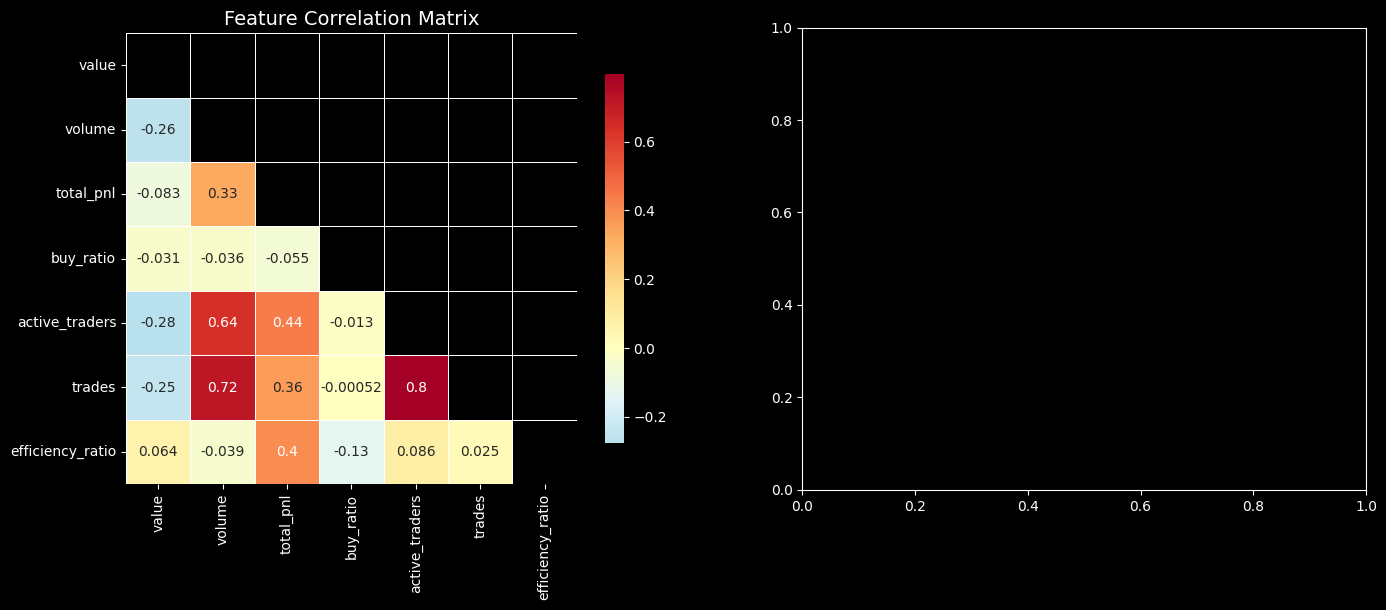

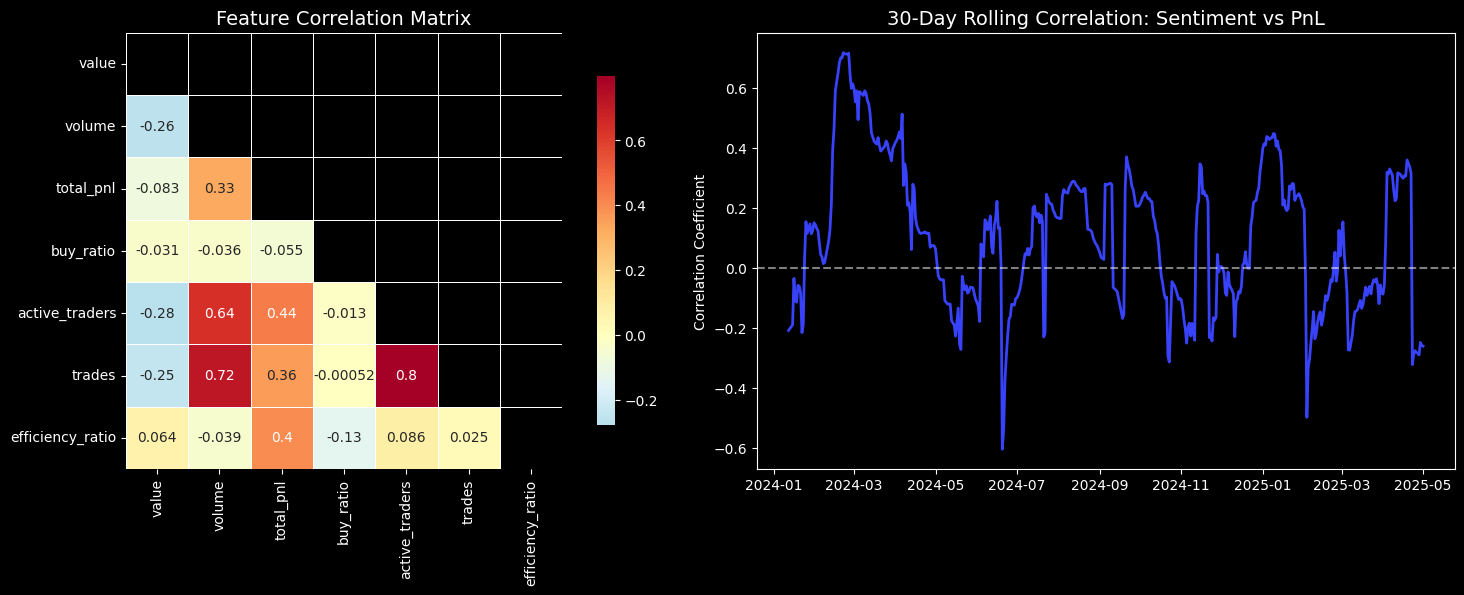


🔗 Strongest Correlations:
• trades ↔ active_traders: 0.797
• active_traders ↔ trades: 0.797
• volume ↔ trades: 0.720
• trades ↔ volume: 0.720
• active_traders ↔ volume: 0.641


In [23]:
correlation_features = ['value', 'volume', 'total_pnl', 'buy_ratio', 'active_traders', 'trades', 'efficiency_ratio']
corr_matrix = merged_data[correlation_features].corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax1)
ax1.set_title('Feature Correlation Matrix', fontsize=14)
# Rolling correlation
rolling = merged_data.set_index('date')[['value', 'total_pnl']].rolling(30).corr()
rolling_corr = rolling.loc[:, 'value'].xs('total_pnl', level=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax1)
ax1.set_title('Feature Correlation Matrix', fontsize=14)

# Rolling correlation plot
ax2.plot(rolling_corr.index, rolling_corr.values, color=emotion_colors['accent'], linewidth=2)
ax2.axhline(y=0, color='white', linestyle='--', alpha=0.5)
ax2.set_title('30-Day Rolling Correlation: Sentiment vs PnL', fontsize=14)
ax2.set_ylabel('Correlation Coefficient')

plt.tight_layout()
plt.savefig('outputs/correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print strongest correlations
strongest_correlations = corr_matrix.abs().unstack().sort_values(ascending=False)
strongest_correlations = strongest_correlations[strongest_correlations < 1.0].head(5)
print("\n🔗 Strongest Correlations:")
for (var1, var2), corr in strongest_correlations.items():
    print(f"• {var1} ↔ {var2}: {corr:.3f}")


## Sentiment-Based Trading Strategies

In [24]:
strategy_analysis = merged_data.copy()
strategy_analysis['sentiment_shift'] = strategy_analysis['sentiment_score'].diff()
strategy_analysis['volume_ma'] = strategy_analysis['volume'].rolling(7).mean()
strategy_analysis['pnl_ma'] = strategy_analysis['total_pnl'].rolling(7).mean()

contrarian_signals = (
    (strategy_analysis['classification'] == 'Extreme Fear') & 
    (strategy_analysis['buy_ratio'] < 0.4)
)
momentum_signals = (
    (strategy_analysis['classification'] == 'Extreme Greed') & 
    (strategy_analysis['buy_ratio'] > 0.6)
)

strategy_analysis['signal'] = 'Hold'
strategy_analysis.loc[contrarian_signals, 'signal'] = 'Contrarian Buy'
strategy_analysis.loc[momentum_signals, 'signal'] = 'Momentum Sell'

signal_performance = strategy_analysis.groupby('signal').agg({
    'total_pnl': ['mean', 'sum', 'count'],
    'volume': 'mean',
    'efficiency_ratio': 'mean'
}).round(4)

signal_performance.columns = ['avg_pnl', 'total_pnl', 'occurrences', 'avg_volume', 'efficiency']

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Strategy Performance', 'Signal Distribution', 
                   'Efficiency Comparison', 'Volume Analysis'),
    specs=[[{"type": "bar"}, {"type": "pie"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

signal_colors = {'Hold': '#95a5a6', 'Contrarian Buy': emotion_colors['fear'], 'Momentum Sell': emotion_colors['greed']}

fig.add_trace(
    go.Bar(x=signal_performance.index, y=signal_performance['avg_pnl'],
           marker_color=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index],
           name='Avg PnL'),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=signal_performance.index, values=signal_performance['occurrences'],
           marker_colors=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index],
           hole=0.4),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=signal_performance.index, y=signal_performance['efficiency'],
           marker_color=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index],
           name='Efficiency'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=signal_performance.index, y=signal_performance['avg_volume'],
           marker_color=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index],
           name='Volume'),
    row=2, col=2
)

fig.update_layout(
    height=800,
    title_text="Trading Strategy Analysis",
    title_x=0.5,
    template='plotly_dark',
    showlegend=False
)

fig.show()
fig.write_image('outputs/strategy_analysis_dashboard.png', width=1200, height=800)

print("\n Strategy Insights:")
print(signal_performance)
best_strategy = signal_performance['avg_pnl'].idxmax()
print(f"\n Best performing strategy: {best_strategy}")
print(f"Average PnL: ${signal_performance.loc[best_strategy, 'avg_pnl']:,.2f}")


 Strategy Insights:
                    avg_pnl     total_pnl  occurrences    avg_volume  \
signal                                                                 
Contrarian Buy  269328.3661  2.693284e+05            1  9.193654e+06   
Hold             21787.3193  9.673570e+06          444  2.593418e+06   
Momentum Sell     9164.3763  3.115888e+05           34  8.949329e+05   

                efficiency  
signal                      
Contrarian Buy      0.0293  
Hold                0.0128  
Momentum Sell       0.0068  

 Best performing strategy: Contrarian Buy
Average PnL: $269,328.37


## Key Findings & Strategic Recommendations

In [29]:
extreme_fear_performance = merged_data[merged_data['classification'] == 'Extreme Fear']['total_pnl'].mean()
extreme_greed_performance = merged_data[merged_data['classification'] == 'Extreme Greed']['total_pnl'].mean()
sentiment_volatility = merged_data.groupby('classification')['total_pnl'].std()
volume_efficiency = merged_data.groupby('classification')['efficiency_ratio'].mean()

insights = {
    'Contrarian Opportunity': f"Extreme Fear periods show {extreme_fear_performance:.2f} avg PnL",
    'Momentum Risk': f"Extreme Greed periods show {extreme_greed_performance:.2f} avg PnL", 
    'Volatility Leader': f"{sentiment_volatility.idxmax()} has highest PnL volatility ({sentiment_volatility.max():.2f})",
    'Efficiency Champion': f"{volume_efficiency.idxmax()} shows best volume efficiency ({volume_efficiency.max():.4f})",
    'Market Participation': f"Average {merged_data['active_traders'].mean():.0f} active traders per day"
}

print("\n")
print("STRATEGIC TRADING INSIGHTS")


for category, insight in insights.items():
    print(f"\n {category}:")
    print(f"   {insight}")

print("\n")


print("\n" + "="*60)
print("Analysis completed successfully!")




STRATEGIC TRADING INSIGHTS

 Contrarian Opportunity:
   Extreme Fear periods show 52793.59 avg PnL

 Momentum Risk:
   Extreme Greed periods show 23817.29 avg PnL

 Volatility Leader:
   Extreme Fear has highest PnL volatility (101262.39)

 Efficiency Champion:
   Extreme Greed shows best volume efficiency (0.0210)

 Market Participation:
   Average 5 active traders per day



Analysis completed successfully!
